In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import find_peaks
import time
import sounddevice as sd
import noisereduce as nr

from spectrogram import Spectogram

In [2]:
spect = Spectogram(linewidth=2, time_step=0.01)

In [3]:
data, sample_rate = sf.read("háttérkép.mp3.mp3")
data = np.sum(data, axis=1)
data.shape

(108793856,)

In [4]:
spect.set(data)

<Axes: >

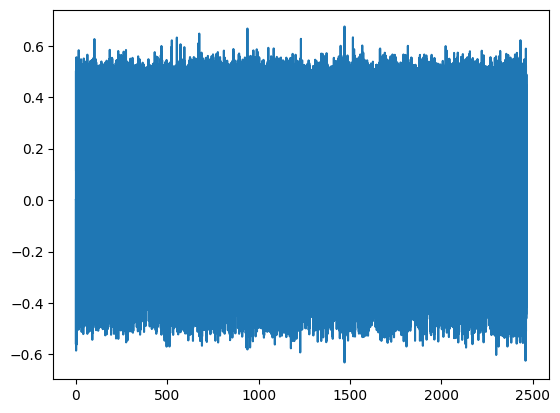

In [5]:
spect.plot_data()

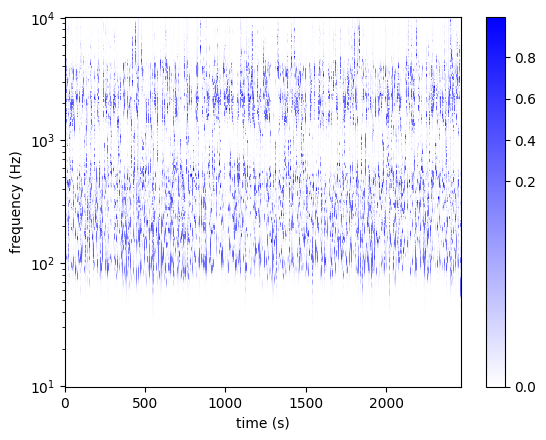

In [6]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

In [32]:
t = 500 #sec
kmax, numax, vmax = spect.find_maxima_in_spectrum(t)[0]
print(f'maximum = {numax:.2f} Hz')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
sample = spect.data_slice(t, t+spect.tint)
times = np.linspace(t, t+spect.tint,len(sample))
ax[0].plot(times, sample)
spect.plot_spectrum(t, ax=ax[1], marker='x')
mesh = spect.plot_octaves_2D(t, ax=ax[2], cmap='viridis')
fig.colorbar(mesh, ax=ax[2])
plt.show()

time 500 is out of range: it must be in [0,4.8]


IndexError: index 480 is out of bounds for axis 0 with size 470

<Axes: >

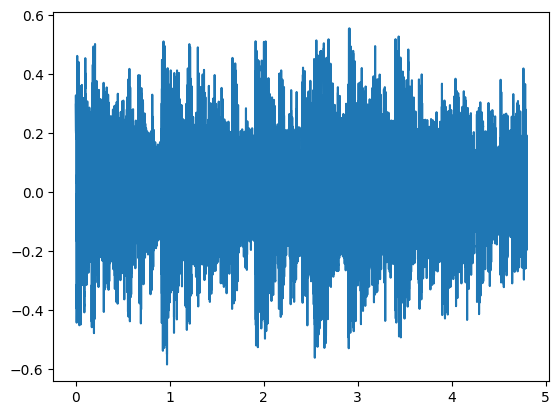

In [13]:
sample =spect.data_slice(0.2,5, data)
spect.set(sample)
spect.plot_data()

In [37]:
spect.play()

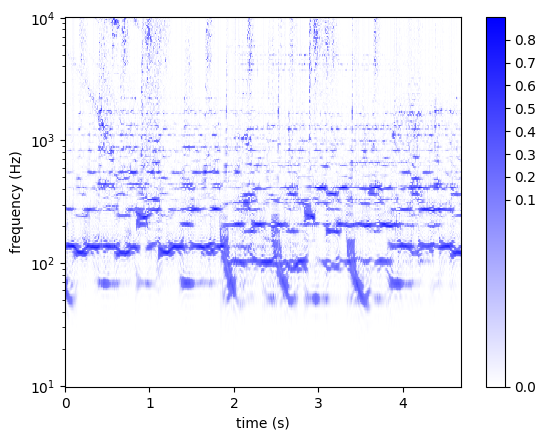

In [34]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

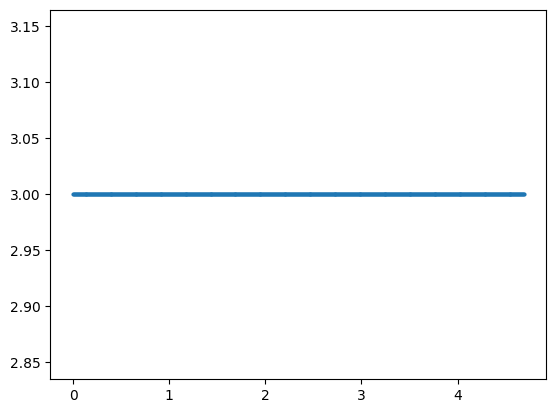

In [38]:
threshold = 0
nmax = 3
times, peaks = spect.find_maxima_in_spectrogram(nmax=nmax, threshold=threshold)
plt.plot(times, [len(v) for v in peaks], 'o', ms=2)

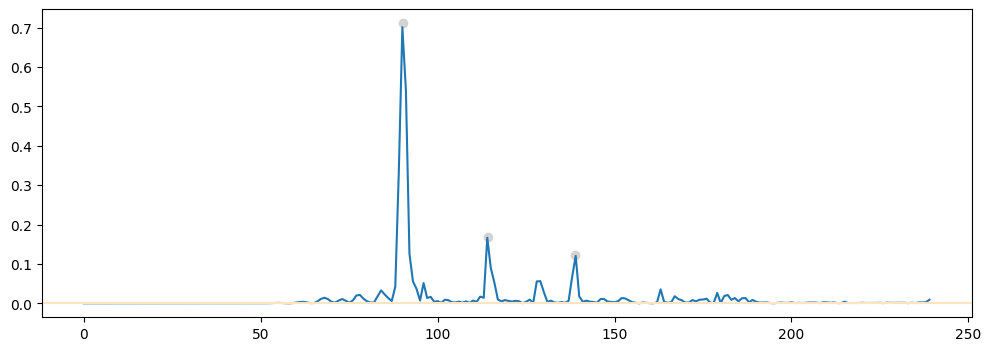

In [39]:
t = 0.35
n = spect.time_to_index(1/spect.timestep, t)
fig,ax = plt.subplots(ncols=1, figsize=(12,4) )
ax.plot(spect.spectrum_data[n])
ax.axhline(threshold,color='bisque')
for pos, freq, height in peaks[n]:
    ax.scatter(pos, height, color='lightgrey')

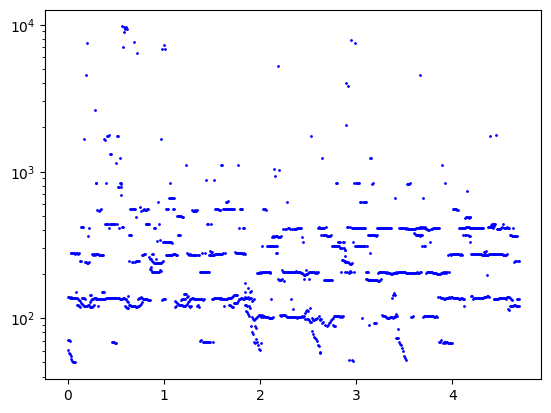

In [40]:
for i,p in enumerate(peaks):
    if len(p)==0:
        continue
    t = times[i]
    plt.plot(t*np.ones(shape=p.shape[0]), p[:,1], 'o', color='blue', ms=1)
plt.yscale('log')
#plt.ylim(75,100)

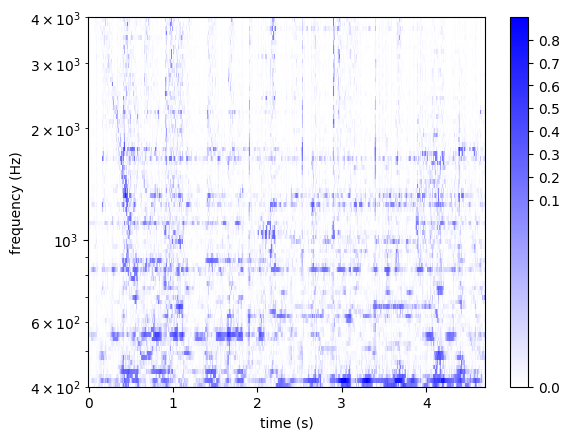

In [19]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
ax.set_ylim(400,4000)
plt.show()

In [101]:
sorted_peaks = np.array(sorted(np.array([ p[:,0] for p in peaks[0:10]]).reshape(-1)))
frequency_bands = [[sorted_peaks[0]]]
factor = 1.1
for p in sorted_peaks[1:]:
    last_band = np.mean(frequency_bands[-1])
    if 2**((p - last_band)/spect.Noctave)> factor:
        frequency_bands.append([p])
    else:
        frequency_bands[-1].append(p)
spect_band = np.array([ spect.numin*2**(np.mean(fb)/spect.Noctave) for fb in frequency_bands])
spect_band/= spect_band[0]
spect_band, np.mean(frequency_bands[0]), np.std(frequency_bands[0])

(array([ 1.        ,  2.01843228,  3.01418643,  4.12631135,  4.94104318,
         6.12193603,  6.88900661,  7.99562   , 11.5175813 , 14.28541954]),
 np.float64(138.47413708160155),
 np.float64(1.1341484614729263))

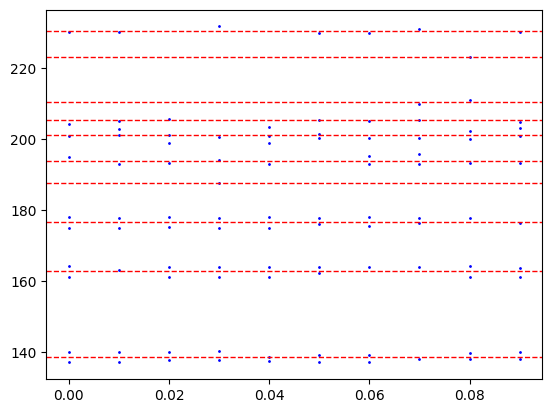

In [105]:
for i,p in enumerate(peaks[:10]):
    if len(p)==0:
        continue
    t = times[i]
    plt.plot(t*np.ones(shape=p.shape[0]), p[:,0], 'o', color='blue', ms=1)
for fb in frequency_bands:
    plt.axhline(np.mean(fb), color='red', ls='--', lw=1)


In [121]:
diffdata = [ ( (times[i]+times[i+1])/2, 2*np.linalg.norm(peaks[i][:,0]-peaks[i+1][:,0])/np.linalg.norm(peaks[i][:,0]+peaks[i+1][:,0])) for i in range(len(peaks)-1)]
diffdata = np.array(diffdata)

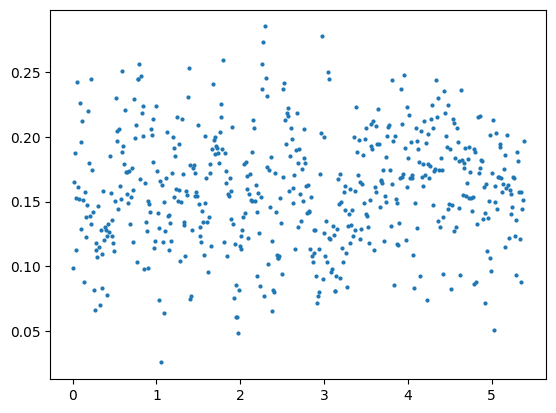

In [122]:
plt.plot(diffdata[:,0], diffdata[:,1], 'o', ms=2)

In [126]:
sorted(peaks[0][:,0]),sorted(peaks[1][:,0])

([np.float64(137.06202780307123),
  np.float64(139.7993875161903),
  np.float64(161.14619845025786),
  np.float64(164.0788104580133),
  np.float64(175.0097551141165),
  np.float64(177.97209398439418),
  np.float64(194.8552578918786),
  np.float64(200.75404816911885),
  np.float64(204.2460894196444),
  np.float64(230.31864957847438)],
 [np.float64(136.99684674231958),
  np.float64(139.83485983898976),
  np.float64(163.07059924651597),
  np.float64(175.0321446005667),
  np.float64(177.86984970002342),
  np.float64(192.98685241367758),
  np.float64(201.03393024851195),
  np.float64(202.96554628782363),
  np.float64(205.22760410713843),
  np.float64(230.29966549808645)])

In [128]:
distance_of_list_of_peaks(peaks[0], peaks[1])

np.float64(1.4602469119106276)

In [129]:
i=0
2*np.linalg.norm(peaks[i][:,0]-peaks[i+1][:,0])/np.linalg.norm(peaks[i][:,0]+peaks[i+1][:,0])

np.float64(0.09890704418594354)

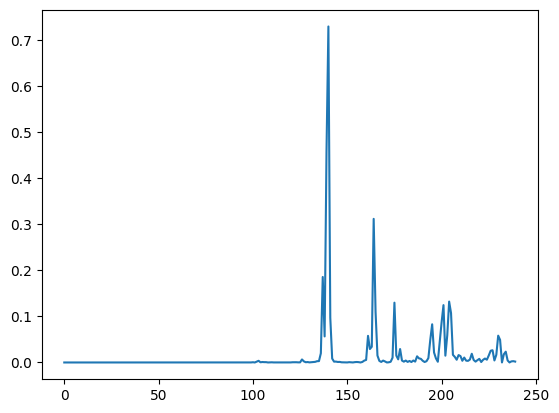

In [131]:
plt.plot(spect.spectrum_data[0])

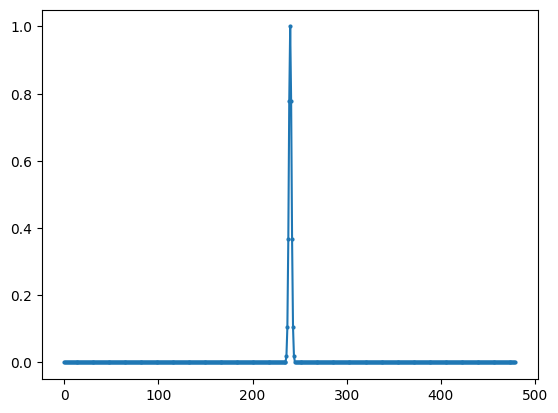

In [145]:
width = 2
length = spect.Nnus
smearfunction = [ np.exp(-((i-length)/width)**2) for i in range(2*length)]
smearM = [ smearfunction[length-i:2*length-i] for i in range(length) ]
plt.plot(smearfunction, 'o-', ms=2)

In [146]:
smearM = np.array(smearM)
smearM.shape

(240, 240)

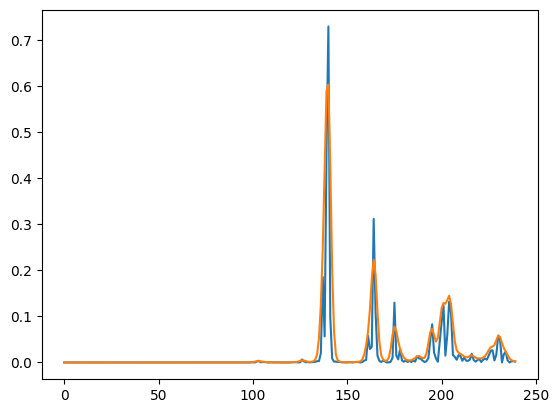

In [147]:
plt.plot(spect.spectrum_data[0])
plt.plot(smearM@spect.spectrum_data[0]/2)

<Axes: >

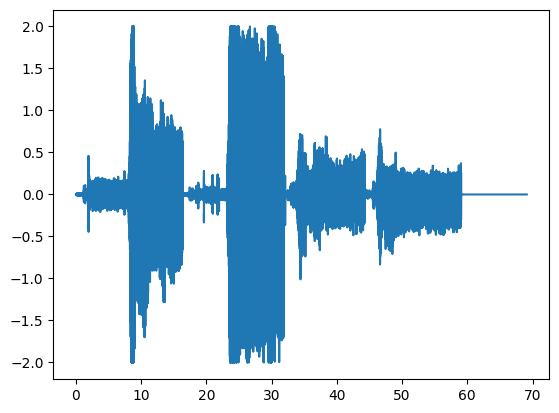

In [40]:
spect.set(data)
spect.plot_data()

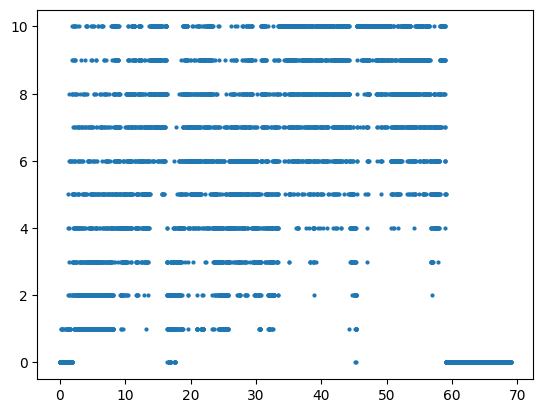

In [82]:
threshold = 0.1
nmax  =10
times, peaks = spect.find_maxima_in_spectrogram(nmax=nmax, threshold=threshold)
plt.plot(times, [len(v) for v in peaks], 'o', ms=2)

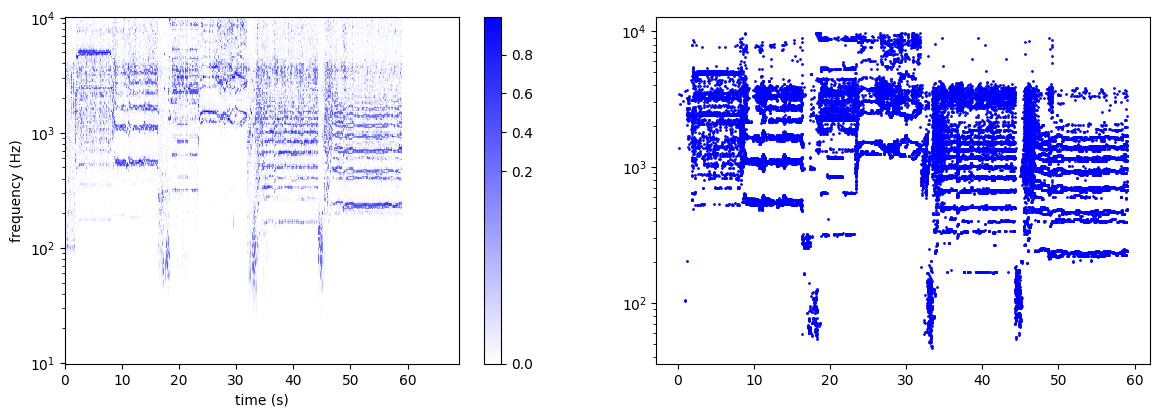

In [83]:
ncols = 2
fig, ax = plt.subplots(ncols=ncols, figsize=(7*ncols, 4.5))
mesh = spect.show_spectrogram(ax=ax[0])
fig.colorbar(mesh, ax=ax[0])
#ax[0].set_ylim(400,4000)

for i,p in enumerate(peaks):
    if len(p)==0:
        continue
    t = times[i]
    ax[1].plot(t*np.ones(shape=p.shape[0]), p[:,1], 'o', color='blue', ms=1)
plt.yscale('log')
plt.show()


In [112]:
distance_of_list_of_peaks(peaks[200], peaks[201])**2

np.float64(0.4591798582177849)

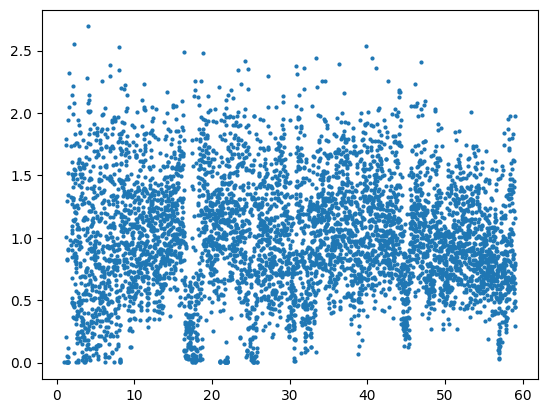

In [113]:

diffdata = [ 
    [(times[i]+times[i+1])/2, distance_of_list_of_peaks(peaks[i],peaks[i+1])] for i in range(len(peaks)-1) if len(peaks[i])>0 and len(peaks[i+1])>0]
diffdata = np.array(diffdata)
plt.plot(diffdata[:,0], diffdata[:,1], 'o', ms=2)

In [78]:
posdiff = []
heightdiff = []
for i in range(len(peaks)-1):
    if len(peaks[i])==0 or len(peaks[i+1])==0:
        continue
    t = (times[i]+times[i+1])/2
    u = peaks[i][:,0]-peaks[i+1][:,0]
    v = peaks[i][:,2]-peaks[i+1][:,2]
    print(peaks[i], peaks[i+1])
    break

[[9.90956237e+01 1.74963772e+02 1.25949775e-02]
 [1.18828512e+02 3.09354262e+02 7.49917555e-03]
 [8.62823215e+01 1.20845909e+02 6.00775610e-03]
 [1.14898100e+02 2.76157773e+02 2.93324442e-03]
 [1.26619173e+02 3.87412570e+02 2.65468235e-03]
 [1.22030224e+02 3.39324256e+02 2.43284221e-03]
 [1.24154909e+02 3.60798439e+02 2.04261611e-03]
 [1.09234578e+02 2.34487765e+02 1.89053400e-03]
 [7.61387236e+01 9.01574566e+01 1.56499343e-03]
 [6.31023479e+01 6.18710490e+01 5.08380882e-04]] [[8.59299348e+01 1.19622258e+02 1.74667691e-02]
 [1.18802480e+02 3.09121764e+02 1.48691739e-02]
 [1.00407518e+02 1.81720161e+02 1.38180150e-02]
 [9.58256033e+01 1.59196142e+02 6.03802974e-03]
 [7.73335259e+01 9.33228421e+01 5.91081304e-03]
 [1.26119832e+02 3.81865582e+02 5.85095298e-03]
 [1.23962398e+02 3.58797991e+02 4.52267350e-03]
 [1.15121978e+02 2.77949153e+02 4.34998786e-03]
 [1.21539809e+02 3.34552035e+02 3.77591242e-03]
 [1.09422050e+02 2.35760820e+02 2.80422763e-03]]


In [38]:
trackers = []
tolerance = 3
quit = False
for pi,p in enumerate(peaks):
    actual_time = times[pi]
    for logpos in p[:,0]:
        foundtrack = []
        for tri,trdata in enumerate(trackers):
            if (logpos-trdata[-1][1])**2 < tolerance**2:
                foundtrack.append(tri)
        print('..................')
        print(logpos, foundtrack)
        if not foundtrack:
            trackers.append([[actual_time, logpos]])
            continue
        if len(foundtrack) >1:
            foundtrack = sorted(foundtrack, key=lambda ft: trackers[ft][-1][0])
            print(f'---------->{logpos},{foundtrack}->{[ trackers[ft][-1] for ft in foundtrack]}->{trackers[foundtrack[-1]]}', flush=True)
            quit=True
        trackers[foundtrack[-1]].append([actual_time, logpos])
        if quit:
            break
    if quit:
        break
trackers


..................
139.7993875161903 []
..................
164.0788104580133 []
..................
137.06202780307123 [0]
..................
204.2460894196444 []
..................
175.0097551141165 []
..................
200.75404816911885 []
..................
139.83485983898976 [0]
..................
136.99684674231958 [0]
..................
163.07059924651597 [1]
..................
205.22760410713843 [2]
..................
140.07397267534864 []
..................
201.1601834616485 [4]
..................
137.63978172685688 [0, 5]
---------->137.63978172685688,[0, 5]->[[0.01, np.float64(136.99684674231958)], [0.02, np.float64(140.07397267534864)]]->[[0.02, np.float64(140.07397267534864)]]


[[[0.0, np.float64(139.7993875161903)],
  [0.0, np.float64(137.06202780307123)],
  [0.01, np.float64(139.83485983898976)],
  [0.01, np.float64(136.99684674231958)]],
 [[0.0, np.float64(164.0788104580133)],
  [0.01, np.float64(163.07059924651597)]],
 [[0.0, np.float64(204.2460894196444)],
  [0.01, np.float64(205.22760410713843)]],
 [[0.0, np.float64(175.0097551141165)]],
 [[0.0, np.float64(200.75404816911885)],
  [0.02, np.float64(201.1601834616485)]],
 [[0.02, np.float64(140.07397267534864)],
  [0.02, np.float64(137.63978172685688)]]]

In [24]:
trackers[0]

[[0.0, np.float64(139.7993875161903)],
 [0.0, np.float64(137.06202780307123)],
 [0.01, np.float64(139.83485983898976)],
 [0.01, np.float64(136.99684674231958)],
 [0.18, np.float64(135.2921415446354)],
 [0.19, np.float64(135.89172830852078)],
 [0.2, np.float64(135.28134350247052)],
 [0.21, np.float64(135.100877684904)],
 [0.21, np.float64(136.85741618122148)],
 [0.22, np.float64(137.00839893271717)],
 [0.22, np.float64(134.97335539229604)],
 [0.23, np.float64(137.03054829029105)],
 [0.23, np.float64(134.481952200458)],
 [0.24, np.float64(136.9191733375746)],
 [0.24, np.float64(135.11915976709543)],
 [0.25, np.float64(136.92907797898755)],
 [0.25, np.float64(135.05407670701553)],
 [0.26, np.float64(136.97295092509592)],
 [0.26, np.float64(134.97363947537696)],
 [0.27, np.float64(136.83533996315683)],
 [0.27, np.float64(135.16970635670683)],
 [0.28, np.float64(135.03686427656612)],
 [0.28, np.float64(136.9434408773046)],
 [0.29, np.float64(136.99774301993745)],
 [0.29, np.float64(134.9725

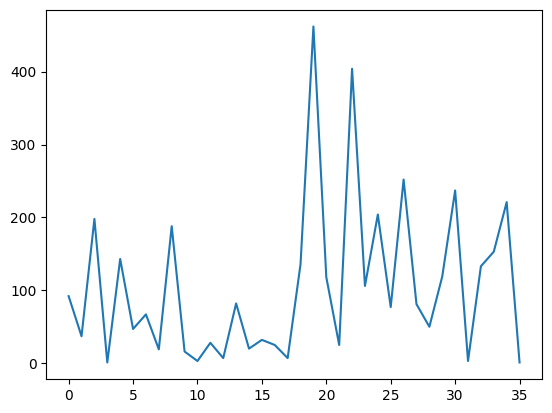

In [23]:
plt.plot([len(tr) for tr in trackers])

(130.0, 150.0)

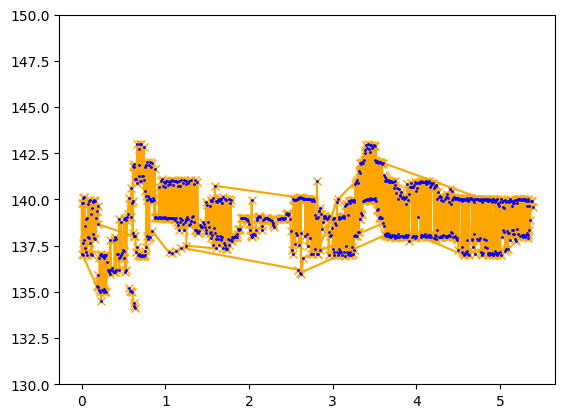

In [19]:
for tr in trackers:
    plt.plot(*np.array(tr).T, 'x-', c='orange')
for i,p in enumerate(peaks):
    if len(p)==0:
        continue
    t = times[i]
    plt.plot(t*np.ones(shape=p.shape[0]), p[:,0], 'o', color='blue', ms=1)
plt.ylim(130,150)


In [20]:
for tr in trackers:
    print(tr[-1])

[0.8, np.float64(137.98498074076062)]
[0.97, np.float64(161.02222639418358)]
[5.38, np.float64(205.97983900971155)]
[0.0, np.float64(175.0097551141165)]
[5.39, np.float64(203.00134584565592)]
[0.76, np.float64(137.22909411783868)]
[4.17, np.float64(178.97104586503022)]
[0.46, np.float64(192.1021884761289)]
[4.58, np.float64(164.26292127527677)]
[5.16, np.float64(222.0259032523668)]
[1.77, np.float64(218.9720882514931)]
[1.6, np.float64(207.8971881745256)]
[4.17, np.float64(210.88033530917306)]
[1.71, np.float64(206.80185673179517)]
[1.5, np.float64(205.17589229530589)]
[1.08, np.float64(188.98133456461443)]
[4.76, np.float64(233.9212110558821)]
[0.64, np.float64(134.10795591598327)]
[3.6, np.float64(180.06146805172492)]
[5.39, np.float64(175.93421843391232)]
[4.99, np.float64(206.25189372992926)]
[4.63, np.float64(136.98749378408903)]
[5.01, np.float64(136.98184172309013)]
[3.5500000000000003, np.float64(189.92568799173833)]
[5.39, np.float64(196.10679637651606)]
[4.01, np.float64(206.

In [21]:
tolerance=3
trackers = [ [[0, int(u), float(v)]] for u,_,v in peaks[0]]
for timeindex, p in enumerate(peaks[1:]):
    for u,_,v in p:
        newitem = [timeindex+1, int(u), float(v)]
        foundtracker = False
        for i,tr in enumerate(trackers):
            if np.abs(tr[-1][1]-u)<tolerance:
                foundtracker=True
                trackers[i].append(newitem)
        if not foundtracker:
            trackers.append([newitem])
len(trackers)


333